# Algorytm Genetyczny - problem komiwojażera

In [1]:
import random
import matplotlib.pyplot as plt
import math
import numpy as np

# Opis algorytmu

Zdecydowałem się na podzielenie algorytmu na odrębne funkcje, a teraz krótkie wyjaśnienie każdej z nich:

- ## Generowanie miast
  Funkcja do generowania miast `generate_cities` tworzy `n_cities` miast na prostokącie o współrzędnych od [0, `x_max`] oraz [0, `y_max`]. Współrzędne są losowane w tym zakresie, a do słownika przechowującego miasta dodawany jest numer jako klucz oraz tuple zawierająca współrzędne jako wartość. Następnie zwracany jest ten słownik.

- ## Inicjalizowanie populacji
  Funkcja ta służy do inicjalizowania populacji początkowej. Chromosom osobnika w tej populacji składa się z numerów miast. Przyjmujemy, że nasz komiwojażer wyrusza z miasta numer 1 i do niego też powraca. Dlatego tworzymy listę kluczy (numerów miast) ze słownika zawierającego miasta i usuwamy miasto o numerze 1, aby nie uwzględniać go w permutacjach. Następnie w pętli o długości rozmiaru naszej populacji permutujemy numery miast, dodajemy na początku i końcu 1, a następnie dodajemy osobnika do populacji. Na koniec zwracamy populację.

- ## Ocena populacji
  Funkcja ta służy do oceny populacji, która jest argumentem funkcji. Najpierw iterujemy przez listę populacji zawierającą poszczególnych osobników. Następnie iterujemy przez długość chromosomu osobnika, obliczając po kolei odległość pomiędzy jego genami (miastami). Ocenę przechowujemy w słowniku, gdzie poszczególnemu chromosomowi (osobnikowi) reprezentowanemu przez tuple, który jest kluczem, przypisujemy ocenę, czyli całkowitą odległość pomiędzy miastami. Następnie sortujemy słownik według jego wartości, aby zwrócić słownik reprezentujący ranking osobników z ich oceną.

- ## Selekcja
  Wybrałem tutaj metodę ruletki bezpośredniej. Na początku tworzymy listę do przechowywania skumulowanych prawdopodobieństw dla każdego chromosomu. Następnie iterujemy przez populację, która jest podana jako słownik posortowany według funkcji oceny (jest to wynik funkcji oceny). Obliczamy dla każdego osobnika prawdopodobieństwo skumulowane, które jest równe sumie prawdopodobieństwa danego osobnika i prawdopodobieństwa wcześniejszych osobników, pomnożone przez `p`, co pozwala na kontrolowanie selekcji. Większe wartości `p` zwiększają szanse wyboru osobników z lepszą funkcją przystosowania. Następnie tworzymy tuple składające się z prawdopodobieństwa i chromosomu, i dodajemy go do listy. Następnie losujemy wartość z zakresu [0, 1] i iterujemy przez listę prawdopodobieństw. Jeśli wylosowana wartość mieści się w zakresie prawdopodobieństwa skumulowanego, to zwracamy chromosom.

- ## Krzyżowanie
  Jako metodę krzyżowania wybrałem krzyżowanie uporządkowane. Na początku losujemy losowy locus początku oraz losowy locus końca zakresu genów, które potomek odziedziczy po pierwszym rodzicu. Pomijając locus pierwszy i ostatni (początek i koniec podróży komiwojażera). Następnie tworzymy potomka wypełnionego wartościami -1. Uzupełniamy wartości w przedziale wylosowanych locusów wartościami. Na początku i końcu potomka dodajemy numer 1, czyli miasto końcowe i początkowe jednocześnie. Następnie w pętli sprawdzamy, czy dany gen drugiego rodzica znajduje się w potomku. Jeśli nie, dodajemy go na pierwszej pozycji, gdzie wartość potomka to -1.

- ## Mutacja
  Jako mutację wybrałem sposób, w którym zamieniamy miejscami dwa losowe allele osobnika. Najpierw tworzymy nowy zmutowany chromosom, obcinając początek i koniec (ponownie, nie chcemy tych pozycji zamieniać). Następnie jeżeli prawdopodobieństwo mutacji przekroczy wartość wylosowanej liczby z zakresu [0, 1], losujemy losowy pierwszy allel do zamiany i inny niż pierwszy losowy drugi allel do zamiany. Po zamianie dodajemy jeszcze etykiety początku i końca podróży na swoje miejsce.

- ## Sukcesja
  Wybrałem wersję sukcesji z częściowym zastępowaniem, ponieważ w teorii posiada wysoką szybkość i dobrą odporność na utykanie w maksimach lokalnych. Na początku tworzymy połączoną populację ze starej i nowej populacji. Następnie oceniamy połączoną populację, tworzymy z niej listę (bo wcześniej była słownikiem) i obcinamy ją do rozmiaru populacji.

- ## Ewolucja
  Warunek końca ewolucji uzależniamy od ilości pokoleń bez poprawy rozwiązania. Na początku inicjalizujemy populację początkową, dokonujemy jej oceny i wybieramy najlepszego osobnika (do porównania z kolejną populacją). Następnie przechodzimy do pętli, która kończy się, gdy spełniony zostanie warunek końca ewolucji. Tworzymy kolejną populację, po kolei wybierając rodziców metodą selekcji bezpośredniej, dokonujemy krzyżowania i mutacji (z określonym prawdopodobieństwem). Następnie po utworzeniu nowej populacji dokonujemy sukcesji z częściowym zastępowaniem. Następnie oceniamy populację i sprawdzamy, czy nastąpiła poprawa rozwiązania względem poprzedniej populacji.


In [2]:
# Funkcje


# Generowanie miast do odwiedzenia
def generate_cities(x_max, y_max, n_cities):
    """Generowanie n_cities losowych miast na kwadracie"""
    cities = {}  # słownik do przechowywania miast
    for i in range(n_cities):
        x = random.randint(0, x_max)
        y = random.randint(0, y_max)
        cities[i+1] = (x, y)  # klucz to numer miasta, a wartość to jego współrzędne

    return cities


def initialize_population(population_size, cities):
    population = []

    city_keys = list(cities.keys())
    city_keys.remove(1)

    for _ in range(population_size):
        permutation = random.sample(city_keys, len(city_keys))
        permutation.insert(0, 1)
        permutation.append(1) 
        population.append(permutation)

    return population
    

# Ocena populacji
def population_assessment(population):
    """Funkcja obliczająca dla populacji odległość między miastami
    i zwracająca posortowany słownik zawierający chromosom i wartośc jego funkcji oceny"""
    assessments = {}
    for chromosome in population:
        total_dist = 0
        for i in range(len(chromosome) - 1):
            current_gene = chromosome[i]
            next_gene = chromosome[i + 1]
            dist = math.dist(cities[current_gene], cities[next_gene])
            total_dist += dist
        assessments[tuple(chromosome)] = total_dist
    sorted_assessments = dict(sorted(assessments.items(), key=lambda item: item[1]))
    return sorted_assessments 


def direct_roulette_selection(population, p):
    """Funkcja dokonująca selekcji z populacji rodziców na podstawie 
    metody ruletki bezpośredniej - wykorzystywana w krzyżowaniu
    (funkcja crossover)"""
    cumulative_probabilities = []
    cumulative_probability = 0

    for chromosome, assessment in population.items():
        cumulative_probability += p * (1 - cumulative_probability)
        cumulative_probabilities.append((cumulative_probability, chromosome))

    random_value = random.random()

    for prob, chromosome in cumulative_probabilities:
        if random_value <= prob:
            return chromosome


def crossover(parent1, parent2):
    """Funkcja dokonująca krzyżowania - 
    tworzenia osobnika potomnego"""
    
    start_locus = random.randint(1, len(parent1) - 2)
    end_locus = random.randint(start_locus, len(parent1) - 2)

    child = [-1] * len(parent1)  # potomek

    child[start_locus:end_locus+1] = parent1[start_locus:end_locus+1]
    child[0] = 1
    child[-1] = 1

    for i in range(len(parent2)):
        gene = parent2[i]
        if gene not in child:
            for j in range(len(child)):
                if child[j] == -1:
                    child[j] = gene
                    break
    
    return child
    

# Na początku prawdopodobieństwo mutacji jest niskie, poźniej może ewnetualnie rosnąć
def mutation(chromosome, mutation_probability):
    """Funkcja dokunująca mutacji"""
    
    mutated_chromosome = chromosome[1:len(chromosome) - 1]
    
    if random.random() < mutation_probability:
        allele_index = random.randint(0, len(mutated_chromosome) - 1)
        allele_index2 = random.randint(0, len(mutated_chromosome) - 1)
    
        while allele_index2 == allele_index:
            allele_index2 = random.randint(0, len(mutated_chromosome) - 1)


        mutated_chromosome[allele_index], mutated_chromosome[allele_index2] = mutated_chromosome[allele_index2], mutated_chromosome[allele_index]

    mutated_chromosome.insert(0, 1)
    mutated_chromosome.append(1)
    
    return mutated_chromosome


# Na początku spróbować sukcesji z częściowym zastępowaniem
def succession(old_population, new_population, population_size):
    """Funkcja dokonująca sukcesji
    czyli utwarzenia nowej populacji na
    bazie nowych potomoków utworzonych w krzyżowniu i mutacji
    i starej populacji"""
    combined_population = old_population + new_population
    
    sorted_combined_population = population_assessment(combined_population)

    new_population = [list(chromosome) for chromosome in sorted_combined_population]
    new_population = new_population[:population_size]
    
    return new_population


def evolution(population_size, prob_of_selection, prob_of_mutation, cities, no_improvement):
    populations = []
    population = initialize_population(population_size, cities) # utworzenie populacji początkowej
    rated_population = population_assessment(population)
    best_solution_previous = next(iter(rated_population.items())) # najlepszy osobnik populacji początkowej
    
    generations_without_improvement = 0 # zmienna kontrolująca ilość populacji bez poprawy rozwiązania
    populations.append(population)
    while generations_without_improvement < no_improvement:
        new_population = []
        for _ in range(population_size):
            parent1 = direct_roulette_selection(rated_population, prob_of_selection)
            parent2 = direct_roulette_selection(rated_population, prob_of_selection)
            child = crossover(parent1, parent2)
            child = mutation(child, prob_of_mutation)
            new_population.append(child)
        
        # Dokonujemy sukcesji z częściowym zastępowaniem
        population = succession(population, new_population, population_size)
        rated_population = population_assessment(population)
        population = [list(chromosome) for chromosome in rated_population]
        populations.append(population)
        # Sprawdzamy, czy doszło do poprawy w najlepszym rozwiązaniu
        best_solution = next(iter(rated_population.items()))
        if best_solution[1] < best_solution_previous[1]:
            best_solution_previous = best_solution
            generations_without_improvement = 0
        else:
            generations_without_improvement += 1
    
    return populations
    


# Wizualizacja wylosowanych miast

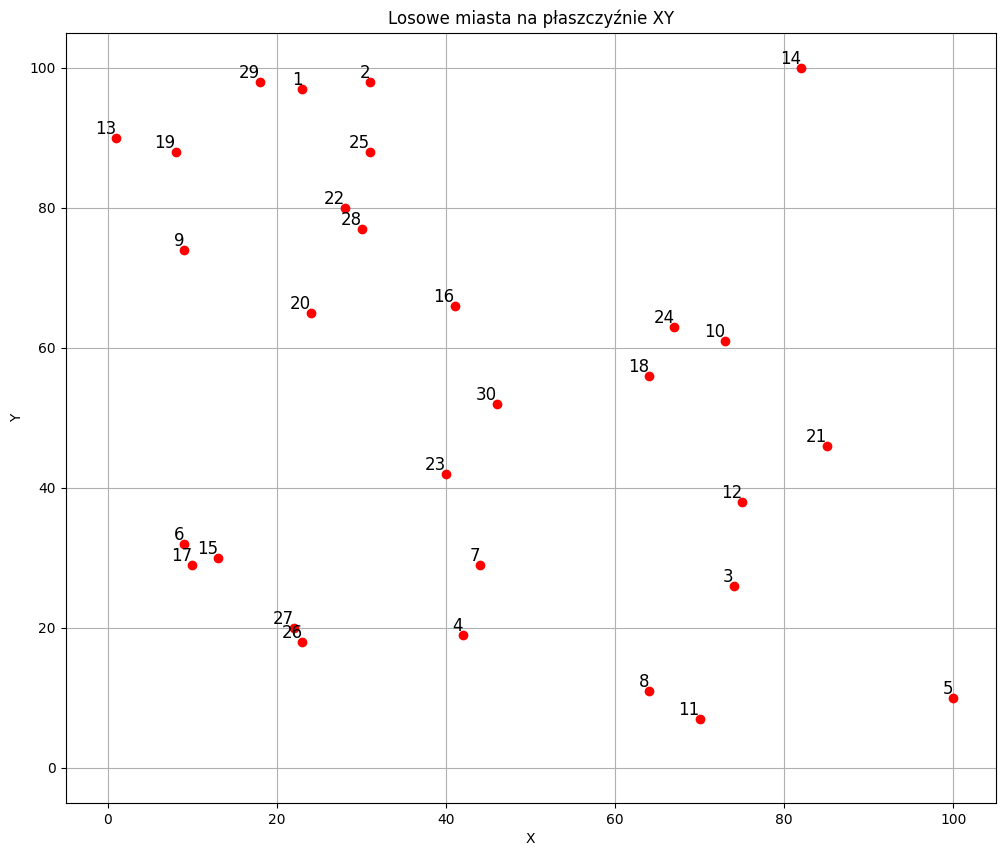

In [3]:
n_cities = 30    # liczba miast do wylosowania
x_max = 100      # maksymalna wspołrzędna x miast
y_max = 100      # maksymalna wspołrzędna y miast
cities = generate_cities(x_max, y_max, n_cities)

plt.figure(figsize=(12, 10), facecolor='white')
for city_id, (x, y) in cities.items():
    plt.plot(x, y, 'ro')  
    plt.text(x, y, city_id, fontsize=12, ha='right', va='bottom')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Losowe miasta na płaszczyźnie XY')
plt.grid(True)
plt.xlim([-5, y_max + 5])
plt.ylim([-5 ,x_max + 5])
plt.show()

In [4]:
population_size = 1000
prob_of_selection = 0.5
prob_of_mutation = 0.1
no_improvement = 100


populations = evolution(population_size, prob_of_selection, prob_of_mutation, cities, no_improvement)

# Wizualizacja trasy odwiedzonych miast

Po dłuższych rozważaniach zdecydowałem się zrezygnować z wyświetlania tras poprzednich pokoleń czy też gorszych od najlepszego rozwiązań, gdyż wprowadzało to zbyt duży chaos na rysynku i zmniejszało jego czytelność wybrałem też mniejszą ilość miast - 30, aby lepiej było to widoczne na rysunku.

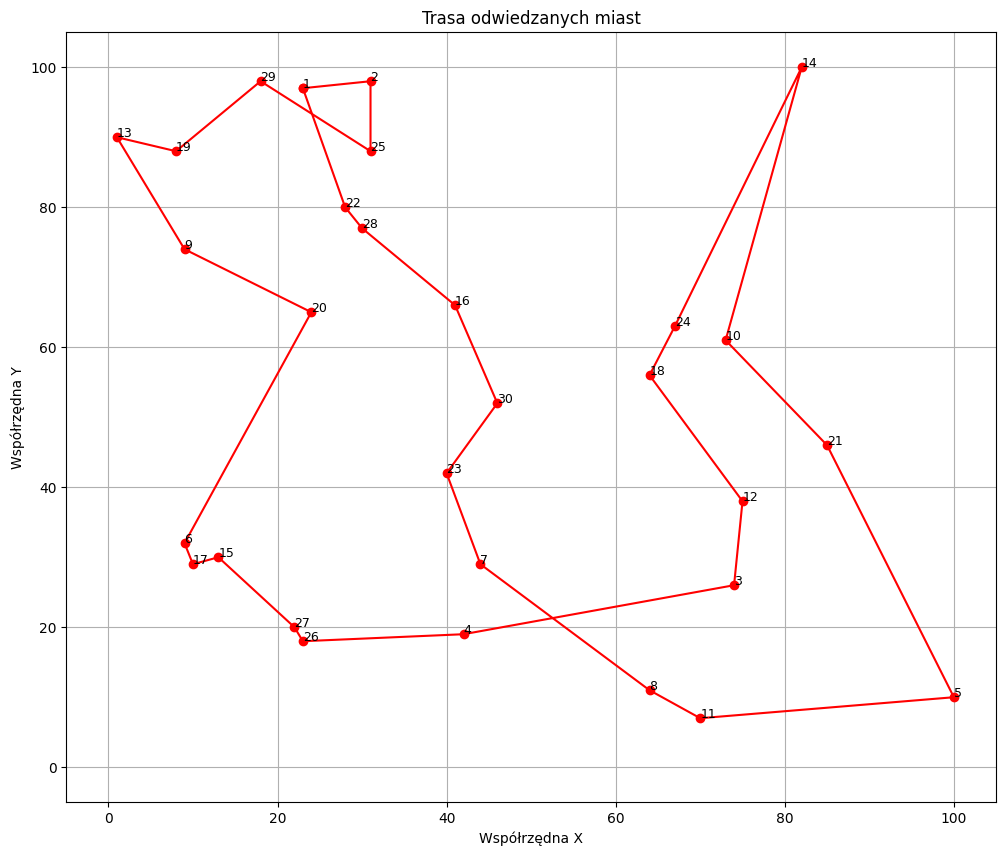

In [5]:
x_coords = []
y_coords = []
for pop in reversed(populations):
    xx_coords = [cities[city][0] for city in pop[0]]
    yy_coords = [cities[city][1] for city in pop[0]]
    x_coords.append(xx_coords)
    y_coords.append(yy_coords)


# num_plots = len(x_coords)
# alpha_values = np.linspace(0.5, 0.1, num_plots)**2

plt.figure(figsize=(12, 10), facecolor='white')
plt.plot(x_coords[0], y_coords[0], marker='o', linestyle='-', color='red',)

# for i in range(len(x_coords) - 1):
#     plt.plot(x_coords[i+1], y_coords[i+1], marker='o', linestyle='-', color='red', alpha=alpha_values[i])

plt.title('Trasa odwiedzanych miast')
plt.xlabel('Współrzędna X')
plt.ylabel('Współrzędna Y')
plt.xlim([-5, x_max + 5])
plt.ylim([-5, y_max + 5])

for city, (x, y) in cities.items():
    plt.text(x, y, str(city), fontsize=9)


plt.grid(True)
plt.show()

# Wizualizacja poprawy funkcji jakości

Na ykresie widać jak poprawia się, czyli w tym przypadku zmniejsza funkcja jakości - maleje odległośc jaką musi pokonać komiwojażer. Tak jak można się było tego spodziewać na początku funkcja poprawia się bardzo szybko, a poźniej następują już tylko delikatne poprawy.

Najlepsze rozwiązanie - wartość funkcji: 521.5045352139908


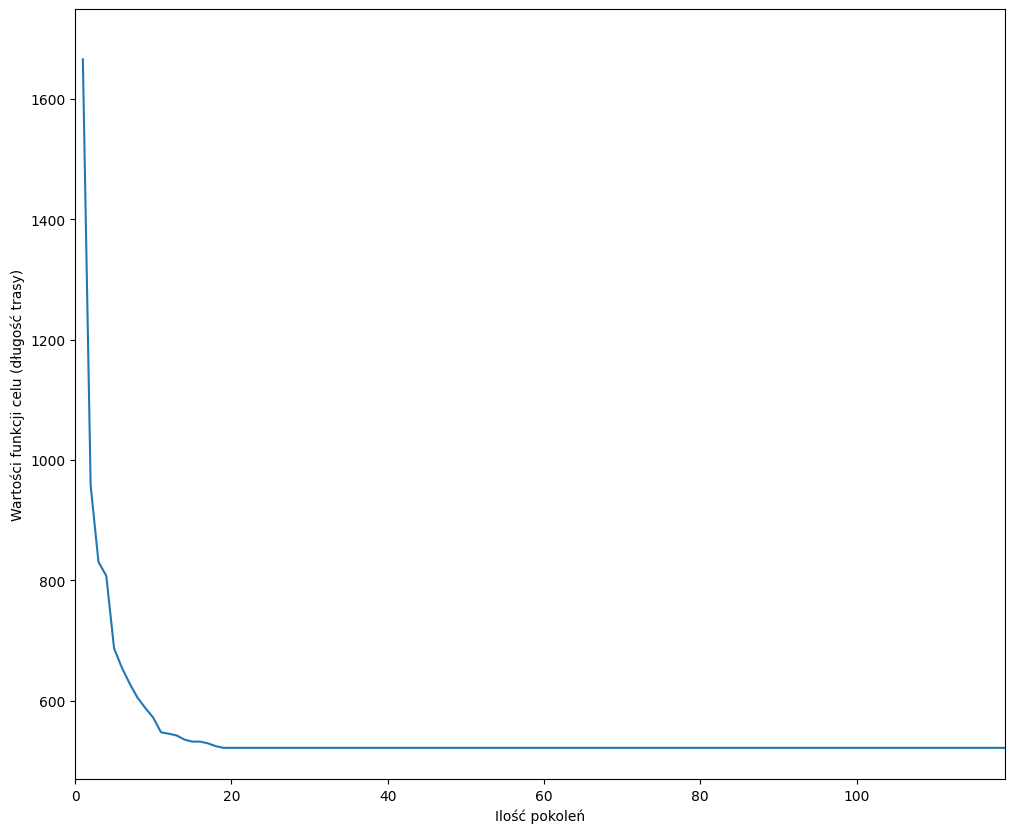

In [6]:
ratings = []
avgs = []

for pop in populations:
    rating = 0
    best = pop[0]
    for i in range(len(best) - 1):
        current_gene = best[i]
        next_gene = best[i + 1]
        dist = math.dist(cities[current_gene], cities[next_gene])
        rating += dist
    
    ratings.append(rating)



print(f'Najlepsze rozwiązanie - wartość funkcji: {ratings[-1]}')
generations = [i+1 for i in range(len(populations))]

plt.figure(figsize=(12, 10))
plt.plot(generations, ratings)
plt.xlim([0, len(populations)])
plt.ylim([ratings[-1] - 0.1 * ratings[-1], ratings[0] + 0.05 * ratings[0]])
plt.xlabel('Ilość pokoleń')
plt.ylabel('Wartości funkcji celu (długość trasy)')

plt.show()

# Wnioski

Z moich obserwacji wynikło, że największy wpływ na poprawę wyniku ewolucji z parametrów miała liczebnośc populacji, jakkolwiek manewrowałbym pozostałymi zmiennymi największą poprawę dawało zwiększenie liczebności populacji. Poza tym zauważyłem, też coś co już było wspominane na wykładach, że po pewnym etapie zmiana metodyki (zmiana metod mutacji, krzyżowania, selekcji, sukcesji) daje małe zmiany i proces ulepszania algorytmu jest bardzo żmudny i powolny. Jednak uważam, że udało się osiągnąć minimum, czyli algorytm dąży do znalezienia coraz to lepszego roazwiązania. Trudno jest też dobrać odpowiednie parametry, próbowałem zwizualizować wpływ np. liczby pokoleń bez poprawy czy prawdopodobieństwa mutacji na wynik ostatecznego rozwiązania, ale raz okazywało się że daje to minimalną poprawę raz, że nie ma to wpływu, jednak za każdym razem gdy było widać że daje to minimalną poprawę to były to raczej zmiany skokowe, chaotyczne i przykładowo kolejne zwiększenie liczby pokoleń bez poprawy dawało już gorszy wynik, jeszcze kolejne, jeszcze gorszy, a potem następowała nagła poprawa. Co oznacza, że było to raczej losowe.